In [1]:
import yfinance as yf
import pandas as pd 
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import statsmodels.api as sm

In [2]:
end_date = datetime.today()
start_date = end_date - timedelta(weeks=26)

# T-bill yield (^IRX)
risk_free = yf.download("^IRX", start=start_date, end=end_date)

# decimal annual rate
risk_free['Annual_Yield'] = risk_free['Close'] / 100

#Convert annual → daily risk-free rate (assuming 252 trading days/year)
trading_days = 252 #actual number of stock market trading days in a typical year U.S. exchanges
risk_free['Daily_Rf'] = (1 + risk_free['Annual_Yield']) ** (1 / trading_days) - 1

risk_free = risk_free[['Daily_Rf']].dropna()
risk_free.reset_index(inplace=True)

risk_free['Daily_Rf'] = risk_free['Daily_Rf']*100
risk_free.columns = risk_free.columns.droplevel(1) 
print(risk_free.head(10))


/tmp/ipykernel_1314543/2614994433.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  risk_free = yf.download("^IRX", start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Price       Date  Daily_Rf
0     2025-02-10  0.016434
1     2025-02-11  0.016423
2     2025-02-12  0.016434
3     2025-02-13  0.016377
4     2025-02-14  0.016377
5     2025-02-18  0.016377
6     2025-02-19  0.016396
7     2025-02-20  0.016347
8     2025-02-21  0.016316
9     2025-02-24  0.016289


In [3]:
# 1. Download Apple and S&P 500 data (last 5 years)
aapl = yf.download('AAPL', start=start_date, end=end_date)
sp500 = yf.download('^GSPC', start=start_date, end=end_date)
aapl.columns = aapl.columns.droplevel(1) 
sp500.columns = sp500.columns.droplevel(1) 
print(aapl.head(2))
print(sp500.head(2))

/tmp/ipykernel_1314543/2283209128.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  aapl = yf.download('AAPL', start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_1314543/2283209128.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download('^GSPC', start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume
Date                                                                
2025-02-10  227.351852  230.288004  226.902445  229.269351  33115600
2025-02-11  232.315353  234.921936  227.831243  227.901144  53718400
Price             Close         High          Low         Open      Volume
Date                                                                      
2025-02-10  6066.439941  6073.379883  6044.839844  6046.399902  4458760000
2025-02-11  6068.500000  6076.279785  6042.339844  6049.319824  4324880000


In [4]:
# Calculate percentage change for multiple columns
cols = ['Close', 'High', 'Low', 'Open']
aapl[[col + '_pct_change' for col in cols]] = aapl[cols].pct_change() * 100
sp500[[col + '_pct_change' for col in cols]] = sp500[cols].pct_change() * 100

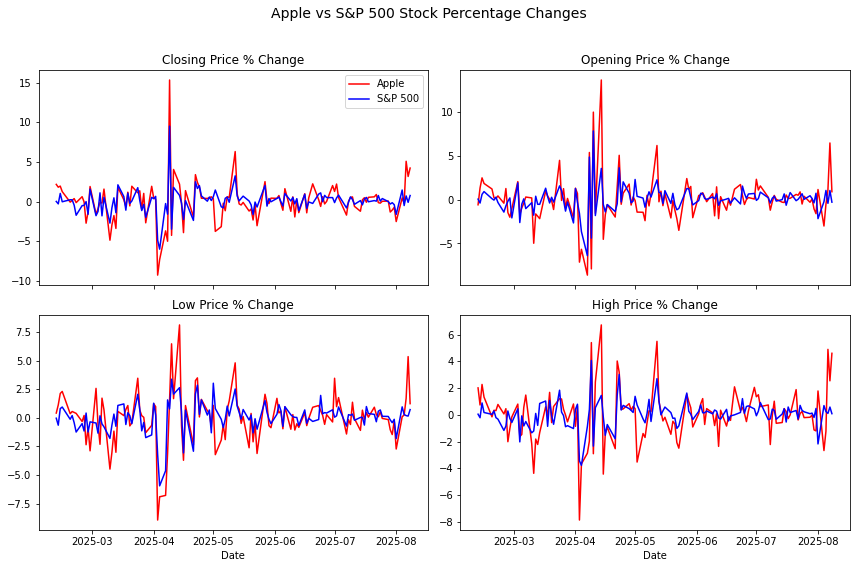

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
fig.suptitle('Apple vs S&P 500 Stock Percentage Changes', fontsize=14)

# Close
axs[0,0].plot(aapl.index, aapl['Close_pct_change'], label='Apple', color='red')
axs[0,0].plot(sp500.index, sp500['Close_pct_change'], label='S&P 500', color='blue')
axs[0,0].set_title('Closing Price % Change')
axs[0,0].legend()

# Open
axs[0,1].plot(aapl.index, aapl['Open_pct_change'], label='Apple', color='red')
axs[0,1].plot(sp500.index, sp500['Open_pct_change'], label='S&P 500', color='blue')
axs[0,1].set_title('Opening Price % Change')

# Low
axs[1,0].plot(aapl.index, aapl['Low_pct_change'], label='Apple', color='red')
axs[1,0].plot(sp500.index, sp500['Low_pct_change'], label='S&P 500', color='blue')
axs[1,0].set_title('Low Price % Change')
axs[1,0].set_xlabel('Date')

# High
axs[1,1].plot(aapl.index, aapl['High_pct_change'], label='Apple', color='red')
axs[1,1].plot(sp500.index, sp500['High_pct_change'], label='S&P 500', color='blue')
axs[1,1].set_title('High Price % Change')
axs[1,1].set_xlabel('Date')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [6]:
"""Apple (red) generally shows sharper and more frequent price swings compared to the S&P 500 (blue), indicating higher volatility.
While both follow similar market trends, Apple’s movements are more pronounced during major events."""

'Apple (red) generally shows sharper and more frequent price swings compared to the S&P 500 (blue), indicating higher volatility.\nWhile both follow similar market trends, Apple’s movements are more pronounced during major events.'

In [7]:
# Merge datasets
data = pd.merge(aapl, sp500, left_index=True, right_index=True, suffixes=('_AAPL', '_SP500'))
data_refined = data[['Close_pct_change_AAPL','Close_pct_change_SP500']]
data_mergered = pd.merge(data_refined,risk_free , on = 'Date', how = 'left')
data_mergered['Excess_AAPL'] = data_mergered['Close_pct_change_AAPL'] - data_mergered['Daily_Rf']
data_mergered['Excess_SP500'] = data_mergered['Close_pct_change_SP500'] - data_mergered['Daily_Rf']
data_mergered = data_mergered.drop(index=0)  

In [8]:
#  Run regression (CAPM)
X = sm.add_constant(data_mergered['Excess_SP500'])  # add intercept for alpha
y = data_mergered['Excess_AAPL']
model = sm.OLS(y, X).fit()

alpha, beta = model.params

print(f"Alpha: {alpha:.6f}")
print(f"Beta: {beta:.4f}")
print(model.summary())

Alpha: -0.029538
Beta: 1.4086
                            OLS Regression Results                            
Dep. Variable:            Excess_AAPL   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     287.7
Date:                Sat, 09 Aug 2025   Prob (F-statistic):           6.97e-34
Time:                        23:53:08   Log-Likelihood:                -215.84
No. Observations:                 124   AIC:                             435.7
Df Residuals:                     122   BIC:                             441.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0

In [9]:
"""
Alpha (-0.0295):
The intercept represents the expected excess return of Apple when the market’s excess return is zero. 
Here, it is slightly negative but statistically insignificant (p = 0.813), which means there is no evidence that Apple has a significant “alpha” 
(abnormal return independent of the market) in this sample.

Beta (1.4086):
The slope coefficient shows how much Apple’s excess return changes for a one-unit change in the market’s excess return. 
Since Beta is greater than 1, Apple is more volatile than the market. Specifically, for every 1% increase in the market’s excess return,
Apple’s excess return tends to increase by approximately 1.41%. This beta is highly statistically significant (p < 0.001),
indicating the market excess return is a strong predictor of Apple’s excess return.

Model Fit
R-squared =  0.702
About 70% of the variation in Apple's excess returns is explained by the S&P 500 excess returns.
The rest (30%) is unexplained by this simple model, possibly due to other factors or noise.
(7O% of the variation is explained by the market, the rest is idiosyncratic)

F-statistic = 287.7, p = 6.97e-34
Very strong evidence the market excess return predicts Apple excess return.

Residual diagnostics indicate some model assumptions could be improved:
Some signs of non-normal residuals and slight autocorrelation suggest more complex models or additional factors might better capture Apple’s return dynamics.
"""

"\nAlpha (-0.0295):\nThe intercept represents the expected excess return of Apple when the market’s excess return is zero. \nHere, it is slightly negative but statistically insignificant (p = 0.813), which means there is no evidence that Apple has a significant “alpha” \n(abnormal return independent of the market) in this sample.\n\nBeta (1.4086):\nThe slope coefficient shows how much Apple’s excess return changes for a one-unit change in the market’s excess return. \nSince Beta is greater than 1, Apple is more volatile than the market. Specifically, for every 1% increase in the market’s excess return,\nApple’s excess return tends to increase by approximately 1.41%. This beta is highly statistically significant (p < 0.001),\nindicating the market excess return is a strong predictor of Apple’s excess return.\n\nModel Fit\nR-squared =  0.702\nAbout 70% of the variation in Apple's excess returns is explained by the S&P 500 excess returns.\nThe rest (30%) is unexplained by this simple mode